In [ ]:
#default_exp audio.core
#default_cls_lvl 3

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.data.all import *
from local.notebook.showdoc import show_doc
import torchaudio
import torchaudio.transforms as torchaud_tfm
import warnings

from IPython.display import display, Audio
from dataclasses import dataclass, asdict, is_dataclass, make_dataclass
from torchaudio.transforms import Spectrogram, AmplitudeToDB, MFCC
from librosa.display import specshow, waveplot

In [ ]:
#export
_all_ = ['AudioGetter', 'get_audio_files', 'AudioItem', 'OpenAudio', 'AudioSpectrogram', 'AudioToSpec',
        'SpectrogramConfig', 'AudioConfig', 'audio_extensions']

## Basic types

This section regroups the basic types used in vision with the transform that create objects of those types.

In [ ]:
#export
audio_extensions = tuple(str.lower(k) for k, v in mimetypes.types_map.items() if v.startswith('audio/'))

In [ ]:
#export
def get_audio_files(path, recurse=True, folders=None):
    "Get image files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=audio_extensions, recurse=recurse, folders=folders)

In [ ]:
#export
def AudioGetter(suf='', recurse=True, folders=None):
    "Create `get_image_files` partial function that searches path suffix `suf` and passes along `kwargs`, only in `folders`, if specified."
    def _inner(o, recurse=recurse, folders=folders): 
        return get_audio_files(o/suf, recurse, folders)
    return _inner

In [ ]:
p = Path("/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS")
URLs.SPEAKERS = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
untar_data(URLs.SPEAKERS, dest=p)

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/ST-AEDS-20180100_1-OS')

In [ ]:
p.ls()

(#3843) [/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00279.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00282.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00432.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00054.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0004_us_m0004_00110.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00180.wav...]

In [ ]:
audio_get_func = AudioGetter("", recurse=True, folders=None)

In [ ]:
files = audio_get_func(p)

In [ ]:
files[0]

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav')


<div class='alert alert-block alert-warning'><strong>Notes:</strong><br> 
    1. Should path really be part of tuple? Leave it for now <br>
</div>


<div class='alert alert-block alert-info'><strong>TO-DO:</strong><br> 
    1. Fix the multichannel display so it can handle a passed in ctx <br>
    2. Get multiple plots to show in proper order, alternating audio->plot->audio->plot. This doesnt work because we delegate plotting to librosa.display.waveplot which plots directly, normally we would create our plot and then call ipython's display on that to show it immediately instead of at the end <br>
</div>

In [ ]:
#export
class AudioItem(tuple):
    def show(self, ctx=None, **kwargs):
        "Show image using `merge(self._show_args, kwargs)`"
        print(f"File: {self.path}")
        self.hear()
        show_audio_signal(self, ctx=ctx, **kwargs)
    
    @classmethod
    def create(cls, fn, **kwargs):
        sig, sr = torchaudio.load(fn)
        return cls((sig, sr, fn))
    
    sig, sr, path = add_props(lambda i, self: self[i], n=3)
    nchannels, nsamples = add_props(lambda i, self: self.sig.shape[i])
    @property
    def duration(self): return self.nsamples/float(self.sr)
    
    def hear(self):
        display(Audio(self.sig, rate=self.sr))

<div class='alert alert-block alert-info'><strong>TO-DO:</strong><br> 
    1. Fix the multichannel display so it can handle a passed in ctx <br>
    2. Get multiple plots to show in proper order, alternating audio->plot->audio->plot. This doesnt work because we delegate plotting to librosa.display.waveplot which plots directly, normally we would create our plot and then call ipython's display on that to show it immediately instead of at the end <br>
</div>

In [ ]:
#export
def show_audio_signal(ai, ctx, **kwargs):
    if(ai.nchannels > 1):
        _,axs = plt.subplots(ai.nchannels, 1, figsize=(6,4*ai.nchannels))
        for i,channel in enumerate(ai.sig):
            waveplot(channel.numpy(), ai.sr, ax=axs[i], **kwargs)
    else:
        axs = plt.subplots(ai.nchannels, 1)[1] if ctx is None else ctx 
        waveplot(ai.sig.squeeze(0).numpy(), ai.sr, ax=axs, **kwargs)

In [ ]:
type(AudioItem((None, None, files[0])))

__main__.AudioItem

In [ ]:
item0 = AudioItem.create(files[0])

In [ ]:
item0.sig.shape

torch.Size([1, 52480])

In [ ]:
item0.sr, item0.nchannels, item0.nsamples, item0.duration

(16000, 1, 52480, 3.28)

In [ ]:
test_eq(type(item0.sig), torch.Tensor)
test_eq(item0.sr, 16000)
test_eq(item0.nchannels, 1)
test_eq(item0.nsamples, 52480)
test_eq(item0.duration, 3.28)

In [ ]:
item0[0]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.5259e-04,
         -6.1035e-05, -1.8311e-04]])

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


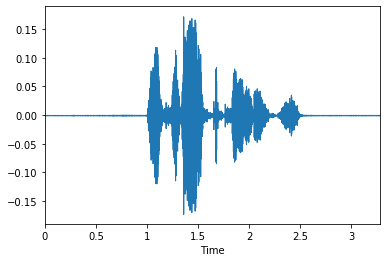

In [ ]:
item0.show()

In [ ]:
item1 = AudioItem.create(files[1]);

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav


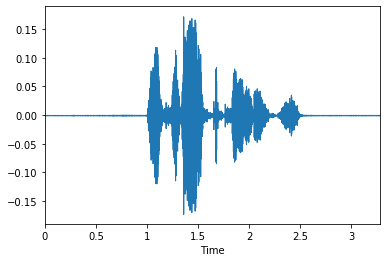

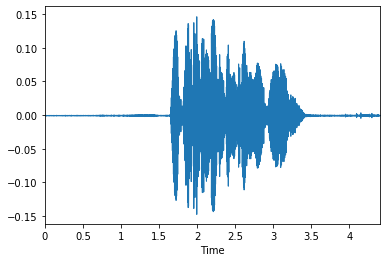

In [ ]:
item0.show()
item1.show()

In [ ]:
#get 3 equal length portions of 3 different signals so we can stack them
#for a fake multichannel example
ai0, ai1, ai2 = map(AudioItem.create, files[2:5]);
min_samples = min(ai0.nsamples, ai1.nsamples, ai2.nsamples)
s0, s1, s2 = map(lambda x: x[:,:min_samples], (ai0.sig, ai1.sig, ai2.sig))

In [ ]:
test_eq(s0.shape, s1.shape)
test_eq(s1.shape, s2.shape)

In [ ]:
fake_multichannel = AudioItem((torch.stack((s0, s1, s2), dim=1).squeeze(0), 16000, None))

In [ ]:
test_eq(fake_multichannel.nchannels, 3)
test_eq(fake_multichannel.nsamples, 53760)

File: None


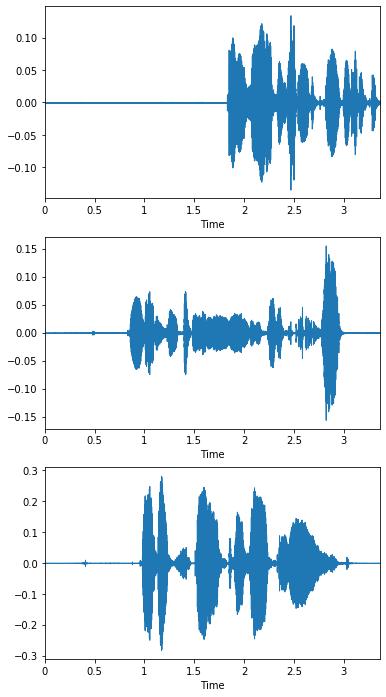

In [ ]:
fake_multichannel.show()

In [ ]:
#export
class OpenAudio(Transform):
    def __init__(self, items):
        self.items = items

    def encodes(self, i):
        o = self.items[i]
        return AudioItem.create(o)
    
    def decodes(self, i)->Path: 
        return self.items[i]

repr of Transform is:  
classname: self.use_as_item {self.encodes} {self.decodes}  
encodes and decodes are TypeDispatches whose reprs are str of dict where k/v pair is typename and function that handles that type

In [ ]:
oa = OpenAudio(files); oa

OpenAudio: True {'object': 'encodes'} {'object': 'decodes'}

In [ ]:
#test open audio on a random set of files
for i in range(10):
    idx = random.randint(0, len(files))
    test_eq_type(oa.encodes(idx), AudioItem.create(files[idx]))
    test_eq_type(oa.decodes(idx), files[idx])

In [ ]:
type(oa)

__main__.OpenAudio

In [ ]:
oa.encodes(0)

(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.5259e-04,
          -6.1035e-05, -1.8311e-04]]),
 16000,
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav'))

In [ ]:
oa.decodes(0)

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav')

In [ ]:
oa.items[0]

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav')

## Create functions to wrap TorchAudio 

In [ ]:
#export
_GenSpec    = torchaudio.transforms.Spectrogram
_GenMelSpec = torchaudio.transforms.MelSpectrogram
_GenMFCC    = torchaudio.transforms.MFCC
_ToDB       = torchaudio.transforms.AmplitudeToDB

<div class='alert alert-block alert-warning'><strong>Note: </strong><br> If a function (e.g. specshow) accepts kwargs, this wont pass extra arguments because specshow doesnt accept all kwargs, and will break if you pass in unexpected ones, but we have no way of knowing what functions they delegate to and pulling out the relevant kwargs, so if there is something we know it accepts as a kwarg like "cmap" we need to pass it in manually  </div>

<div class='alert alert-block alert-warning'><strong>Note: </strong><br>Add func only works if all args are keyword arguments, doesnt work for unnamed args. Could add in a get usable args that checks if default is inspect._empty. This also needs more tests</div>  

In [ ]:
#export
def get_usable_kwargs(func, args, exclude):
    exclude = ifnone(exclude, [])
    defaults = {k:v.default for k, v in inspect.signature(func).parameters.items() if k not in exclude}
    usable = {k:v for k,v in args.items() if k in defaults}
    return {**defaults, **usable}

# def add_func(func, kwargs):
#     func_args = get_usable_kwargs(func, kwargs, [])
#     return func(**func_args)

In [ ]:
args = {'a':1, 'b':2}
extra_args = {'z':0, 'a':1, 'b':2, 'c':3}
test_eq(get_usable_kwargs(operator.add,       args, []), args)
test_eq(get_usable_kwargs(operator.add, extra_args, []), args)

## Audio Spectrogram

<div class='alert alert-block alert-info'><strong>TO-DO:</strong><br>
    1. Add proper axis labels based on settings, get colorbar working <br>
    2. Clean up/Refactor <br>
    3. Add testing for plotting various channels/deltas<br>
</div>

<div class='alert alert-block alert-warning'><strong>Note: </strong><br> Overriding getattr to store the settings isnt ideal, but if we dump them all in as attributes by doing `x.__dict__.update(settings)` we then can't easily pass settings when we do a transform and create a new AudioSpectrogram objct. Potential fixes are<br>
1. Having both a settings dict and updating the dict with all its attributes (this feels dirty)<br>
2. Finding a way to implement deepcopy for AudioSpectrogram so that we can clone it efficiently<br>
3. Dumping the spectrogram settings and having a method that collects them so it can be passed to the constructor when we make a new AudioSpectrogram object in a transform<br>
</div>

In [ ]:
#export
class AudioSpectrogram(TensorImageBase):
    @classmethod
    def create(cls, sg, settings=None):
        x = cls(sg)
        x.settings = settings
        return x
        
    @property
    def duration(self):
        # spectrograms round up length to fill incomplete columns,
        # so we subtract 0.5 to compensate, still wont be exact
        return (self.hop_length*(self.shape[-1]-0.5))/self.sr
    nchannels, height, width = add_props(lambda i, self: self.shape[i], n=3)
    
    def __getattr__(self, name):
        if name == "settings": return None
        if self.settings is not None and name in self.settings: return self.settings[name]    
        raise AttributeError(f"{self.__class__.__name__} object has no attribute {name}")
        
#     def show(self, figsize=None, ax=None, ctx=None, **kwargs):
#         ax = ifnone(ax,ctx)
#         nchannels = self.nchannels
#         r, c = nchannels, self.data.shape[0]//nchannels
#         proper_kwargs = get_usable_kwargs(specshow, self.settings, omit=["kwargs", "data",])
#         if (r == 1 and c == 1):
#             _ = specshow(self.data.squeeze(0).numpy(), **self._show_args, **proper_kwargs)
            
#         else:
#             if figsize is None: figsize = (4*c, 3*r)
#             if ax is None: _,ax = plt.subplots(r, c, figsize=figsize)
#             for i, channel in enumerate(self.data):
#                 cur_ax = ax[i//c,i%c] if r > 1 else ax[i%c]
#                 cur_ax.set_title(f"Channel {i//c} Image {i%c}")
#                 _ = specshow(channel.numpy(), ax=cur_ax, **self._show_args, **proper_kwargs)
    
    

<div class='alert alert-block alert-warning'><strong>Note:</strong><br> Would it be better to use Pipeline here instead of nn.sequential?. I tried it and the repr for Pipeline breaks when using MelSpectrogram but works fine with nn.Sequential, so we can worry about this later</div>

<div class='alert alert-block alert-warning'><strong>Note:</strong><br> _validate and _warn_kwargs should probably be abstracted up a level, they dont belong to AudioToSpec class and could be useful to check args in general.
</div>

# Spectrogram Generation, AudioToSpec

In [ ]:
#export
@delegates(_GenSpec.__init__)
@delegates(_GenMelSpec.__init__, keep=True)
@delegates(_ToDB.__init__, keep=True)
class AudioToSpec(Transform):
    def __init__(self, mel=True, to_db=True, **kwargs):
        self._validate_kwargs(mel, to_db, kwargs)
        transforms = L()
        kwargs = self.add_local_defaults(dict(kwargs))
        if mel:   transforms += self.add_func(_GenMelSpec, kwargs)
        else:     transforms += self.add_func(_GenSpec, kwargs)
        if to_db: transforms += self.add_func(_ToDB, kwargs)
        
        self.transformer = nn.Sequential(*transforms)
        store_attr(self, 'to_db,mel')
        self.__dict__.update(kwargs)
        
    @classmethod
    def from_cfg(cls, audio_cfg):
        cfg = asdict(audio_cfg) if is_dataclass(audio_cfg) else audio_cfg
        return cls(**cfg)
    
    def encodes(self, x:AudioItem):
        settings = dict(self.__dict__)
        settings.update({'sr':x.sr, 'nchannels':x.nchannels, 'path':x.path})
        return AudioSpectrogram.create(self.transformer(x.sig).flip(1).detach(), settings=settings)
    
    def add_func(self, func, kwargs):
        func_args = get_usable_kwargs(func, kwargs, [])
        self.__dict__.update(func_args)
        return func(**func_args)
    
    def add_local_defaults(self, kwargs):
        if "n_fft" not in kwargs or kwargs["n_fft"] is None:            kwargs["n_fft"] = 1024
        if "win_length" not in kwargs or kwargs["win_length"] is None:  kwargs["win_length"] = kwargs["n_fft"] 
        if "hop_length" not in kwargs or kwargs["hop_length"] is None:  kwargs["hop_length"] = int(kwargs["win_length"]/2)
        return kwargs
    
    @staticmethod
    def _validate_kwargs(mel, to_db, kwargs):
        funcs = [_GenMelSpec, _GenSpec, _ToDB]
        all_args = set().union(*map(lambda x: set(inspect.signature(x).parameters.keys()), funcs))
        for k, v in kwargs.items():
            if k not in all_args:
                warnings.warn(f"{k} is not a valid arg name, usable kwargs are {all_args}")
        if mel:       AudioToSpec._warn_kwargs(_GenMelSpec, _GenSpec, kwargs)  
        else  :       AudioToSpec._warn_kwargs(_GenSpec, _GenMelSpec, kwargs)
        if not to_db: AudioToSpec._warn_kwargs(noop, _ToDB, kwargs)
    
    @staticmethod
    def _warn_kwargs(used, unused, kwargs):
        def get_bad_args(f1, f2):
            a1, a2 = map(lambda x: set(inspect.signature(x).parameters.keys()), (f1, f2))
            return a2 - a1
        bad_args = get_bad_args(used, unused)
        for k, v in kwargs.items():
            if(k in bad_args):
                warnings.warn(f"{k} passed in but unused, your settings use {used} not {unused}")

In [ ]:
a2s = AudioToSpec()

In [ ]:
oa = OpenAudio(files)
item100 = oa.encodes(100)

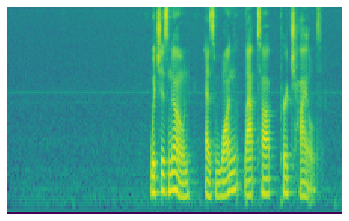

In [ ]:
# get a sg with weird settings for testing
a2s = AudioToSpec(f_max=20000, n_mels=137)
sg = a2s(item100)
sg.show()

In [ ]:
sg.shape

<<<<<<< local <modified: text/plain>


torch.Size([1, 137, 222])

torch.Size([1, 128, 414])

>>>>>>> remote <modified: text/plain>


In [ ]:
#test the explicit settings were properly stored in the spectrogram object
test_eq(sg.f_max, 20000)
test_eq(sg.hop_length, 512)
test_eq(sg.sr, item100.sr)
test_eq(sg.mel, True)
test_eq(sg.to_db, True)
test_eq(sg.nchannels, 1)
test_eq(sg.height, 137)
test_eq(sg.n_mels, sg.height)
test_eq(sg.width, 222)

In [ ]:
sg.settings

{'sample_rate': 16000,
 'n_fft': 1024,
 'win_length': 1024,
 'hop_length': 512,
 'f_min': 0.0,
 'f_max': 20000,
 'pad': 0,
 'n_mels': 137,
 'window_fn': <function _VariableFunctions.hann_window>,
 'wkwargs': None,
 'stype': 'power',
 'top_db': None,
 'transformer': Sequential(
   (0): MelSpectrogram(
     (spectrogram): Spectrogram()
     (mel_scale): MelScale()
   )
   (1): AmplitudeToDB()
 ),
 'to_db': True,
 'mel': True,
 'sr': 16000,
 'nchannels': 1,
 'path': PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00340.wav')}

In [ ]:
sg.nchannels, sg.height, sg.width

<<<<<<< local


(1, 137, 222)

>>>>>>> remote


<<<<<<< local <removed>


(1, 128, 414)

>>>>>>> remote <modified: text/plain>


In [ ]:
defaults = {k:v.default for k, v in inspect.signature(_GenMelSpec).parameters.items()}
a2s = AudioToSpec(f_max=20000, hop_length = 345)
sg = a2s(item100)
test_eq(sg.n_mels, defaults["n_mels"])
test_eq(sg.n_fft , 1024)
test_eq(sg.shape[1], sg.n_mels)
test_eq(sg.hop_length, 345)

In [ ]:
sg.transformer

Sequential(
  (0): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
  (1): AmplitudeToDB()
)

In [ ]:
sg.hop_length

345

In [ ]:
sg.settings

{'sample_rate': 16000,
 'n_fft': 1024,
 'win_length': 1024,
 'hop_length': 345,
 'f_min': 0.0,
 'f_max': 20000,
 'pad': 0,
 'n_mels': 128,
 'window_fn': <function _VariableFunctions.hann_window>,
 'wkwargs': None,
 'stype': 'power',
 'top_db': None,
 'transformer': Sequential(
   (0): MelSpectrogram(
     (spectrogram): Spectrogram()
     (mel_scale): MelScale()
   )
   (1): AmplitudeToDB()
 ),
 'to_db': True,
 'mel': True,
 'sr': 16000,
 'nchannels': 1,
 'path': PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00340.wav')}

<<<<<<< local <modified: text/plain>


<<<<<<< local


>>>>>>> remote <modified: text/plain>


<<<<<<< local


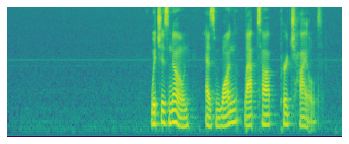

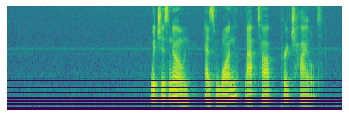

>>>>>>> remote


<<<<<<< local <unchanged>


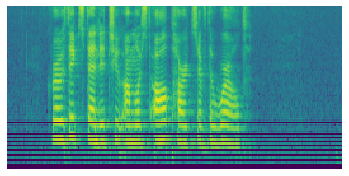

>>>>>>> remote <removed>


>>>>>>> remote


In [ ]:
sg.show()

In [ ]:
sg.shape

<<<<<<< local <modified: text/plain>


torch.Size([1, 128, 329])

torch.Size([1, 128, 414])

>>>>>>> remote <modified: text/plain>


In [ ]:
# test the spectrogram and audio have same duration, both are computed
# on the fly as transforms can change their duration
test_close(sg.duration, item100.duration, eps=0.001)

AssertionError: close:
7.08328125
7.08

## Test warnings for missing/extra arguments

In [ ]:
#export
def test_warns(f, args, kwargs, show=False):
    with warnings.catch_warnings(record=True) as w:
        test_eq(len(w), 0)
        f(*args, **kwargs)
        test_ne(len(w), 0)
        if show: 
            for e in w: print(f"{e.category}: {e.message}")

In [ ]:
SHOW_W=False

In [ ]:
#test warning for unused argument 'power' for melspec
#tests AudioToSpec and its from_cfg class method
voice_mel_cfg = {'n_fft':2560, 'f_max':22050., 'n_mels':128, 'hop_length':256, 'power':2}
test_warns(AudioToSpec, [], voice_mel_cfg, show=SHOW_W)
test_warns(AudioToSpec.from_cfg, [voice_mel_cfg], {}, show=SHOW_W)

In [ ]:
#test for unused arguments 'f_max' and 'n_mels' for non-mel Spectrogram
voice_mel_cfg = {'f_max':22050., 'n_mels':128, 'n_fft':2560, 'hop_length':256, 'power':2}
test_warns(AudioToSpec, [], {"mel":False, **voice_mel_cfg}, show=SHOW_W)

In [ ]:
#test warning for unused argument 'top_db' when db conversion not done
voice_mel_cfg = {'top_db':20, 'n_fft':2560, 'f_max':22050., 'n_mels':128, 'hop_length':256}
test_warns(AudioToSpec, [], {"to_db":False, **voice_mel_cfg}, show=SHOW_W)

In [ ]:
#test warning for invalid argument 'doesntexist'
voice_mel_cfg = {'doesntexist':True, 'n_fft':2560, 'f_max':22050., 'n_mels':128, 'hop_length':256}
test_warns(AudioToSpec, [], {"to_db":False, **voice_mel_cfg}, show=SHOW_W)

<div class='alert alert-block alert-warning'><strong>Issue:</strong><br>
    Pipe is only displaying one thing instead of multiple, this is because I am not strong with matplotlib and the plot is being overwritten each time show is called, get someone who knows this and how it fits into fastai to fix
</div>

# MFCC Generation

<div class='alert alert-block alert-warning'><strong>Issue:</strong><br>
    MFCC is based on a melspectrogram so it accepts a bunch of the same arguments, but instead of passing them in explicitly, they are passed as a dict to "melkwargs". As a result, in the current state the mfcc has no current info about the hop_length (determines the width) that it was generated with. One option is grabbing the defaults from _GenMelSpec inside AudioToMFCC and pass it into the sg_settings. OTOH this could be an argument for lumping everything into AudioToSpec, including MFCC, and then we'd have the same access to _GenMelSpec arguments for tab-completion. We could also make AudioToMFCC have a 2nd delegation to _GenMelSpec, and then parse the MelSpec arguments ourselves and bundle them into melkwargs before passing them to torchaudio. This would break our concept of wrapping the external functions in internal references like _GenMelSpec, because we'd no longer be agnostic to how theyre implemented. One last note is that melkwargs will not accept extra keywords, only the ones that torchaudio.transforms.MelSpectrogram expects. <br>
</div>

In [ ]:
#export
@delegates(_GenMFCC.__init__)
class AudioToMFCC(Transform):
    def __init__(self,**kwargs):
        func_args = get_usable_kwargs(_GenMFCC, kwargs, [])
        self.transformer = _GenMFCC(**func_args)
        self.settings = func_args
        
    @classmethod
    def from_cfg(cls, audio_cfg):
        cfg = asdict(audio_cfg) if is_dataclass(audio_cfg) else audio_cfg
        return cls(**cfg)
    
    def encodes(self, x:AudioItem):
        sg_settings = {"sr":x.sr, **self.settings}
        return AudioSpectrogram.create(self.transformer(x.sig).flip(1).detach(), settings=sg_settings)

In [ ]:
a2mfcc = AudioToMFCC()
mfcc = a2mfcc(item100)
test_eq(mfcc.n_mfcc, mfcc.data.shape[1])

<<<<<<< local <modified: text/plain>


<<<<<<< local


>>>>>>> remote <modified: text/plain>


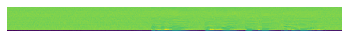

>>>>>>> remote


<<<<<<< local <unchanged>


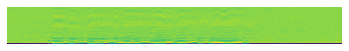

>>>>>>> remote <removed>


In [ ]:
mfcc.show()

In [ ]:
mfcc.settings

{'sr': 16000,
 'sample_rate': 16000,
 'n_mfcc': 40,
 'dct_type': 2,
 'norm': 'ortho',
 'log_mels': False,
 'melkwargs': None}

In [ ]:
mfcc.height

30

In [ ]:
mfcc.width

567

torch.Size([1, 67, 567])


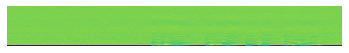

In [ ]:
#n_mfcc specified should determine the height of the mfcc
n_mfcc = 67
a2mfcc67 = AudioToMFCC(n_mfcc=n_mfcc)
mfcc67 = a2mfcc67(item100)
test_eq(mfcc67.shape[1], n_mfcc)
mfcc67.show()
print(mfcc67.shape)

### Example of passing in melkwargs 

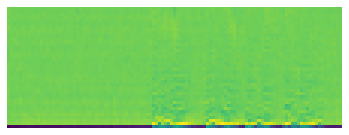

In [ ]:
a2mfcc_kwargs = AudioToMFCC(melkwargs={"hop_length":1024, "n_fft":1024})
mfcc_kwargs = a2mfcc_kwargs(item100)
mfcc_kwargs.show()
# make sure a new hop_length changes the resulting width
test_ne(mfcc_kwargs.width, mfcc.width)

# Example Pipelines

### DB MelSpectrogram Pipe (Standard)

Shape 0 torch.Size([1, 128, 821])
Shape 1 torch.Size([1, 128, 1101])
Shape 2 torch.Size([1, 128, 1331])
Shape 3 torch.Size([1, 128, 841])
Shape 4 torch.Size([1, 128, 951])


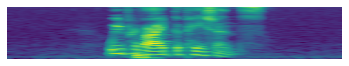

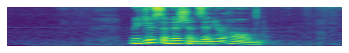

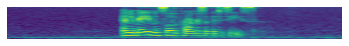

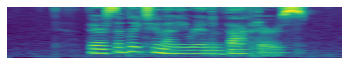

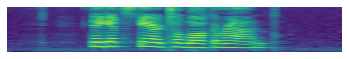

In [ ]:
mel_cfg = {'n_fft':2560,'hop_length':64}
oa = OpenAudio(files)
a2s = AudioToSpec(**mel_cfg)
db_mel_pipe = Pipeline([oa,a2s], as_item=True)
for i in range(5):
    print("Shape", i, db_mel_pipe(i).shape)
    db_mel_pipe.show(db_mel_pipe(i))

### Raw Spectrogram (non-mel, non-db) Pipe

<<<<<<< local


<<<<<<< local <modified: >


Shape 0 torch.Size([1, 513, 411])
Shape 1 torch.Size([1, 513, 551])
Shape 2 torch.Size([1, 513, 666])


>>>>>>> remote


<<<<<<< local <unchanged>


Shape 0 torch.Size([1, 201, 456])
Shape 1 torch.Size([1, 201, 736])
Shape 2 torch.Size([1, 201, 681])


Shape 0 torch.Size([1, 201, 411])
Shape 1 torch.Size([1, 201, 551])
Shape 2 torch.Size([1, 201, 666])


>>>>>>> remote <modified: >


<<<<<<< local


>>>>>>> remote <modified: >


<<<<<<< local


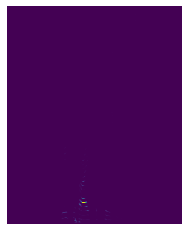

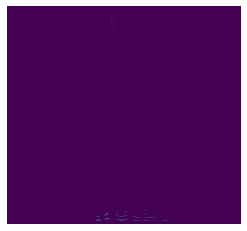

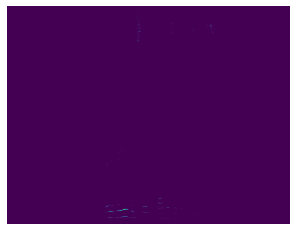

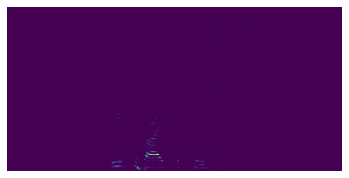

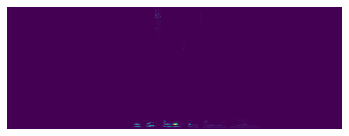

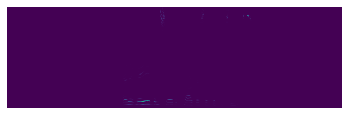

>>>>>>> remote


<<<<<<< local <unchanged>


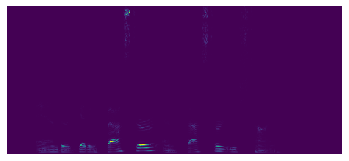

>>>>>>> remote <removed>


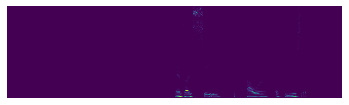

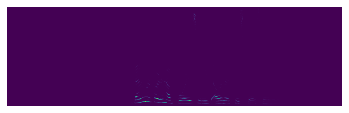

>>>>>>> remote


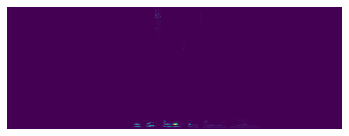

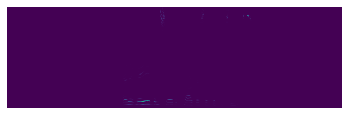

In [ ]:
cfg = {'hop_length':128}
oa = OpenAudio(files)
db_mel_pipe = Pipeline([oa, AudioToSpec(mel=False, to_db=False, **cfg)], as_item=True)
for i in range(3):
    print("Shape", i, db_mel_pipe(i).shape)
    db_mel_pipe.show(db_mel_pipe(i))
    test_eq(db_mel_pipe(i).hop_length, cfg["hop_length"])

### DBScale non-melspectrogram Pipe

<<<<<<< local


<<<<<<< local <modified: >


Shape 0 torch.Size([1, 513, 103])
Shape 1 torch.Size([1, 513, 138])
Shape 2 torch.Size([1, 513, 167])


>>>>>>> remote


<<<<<<< local <unchanged>


Shape 0 torch.Size([1, 201, 292])
Shape 1 torch.Size([1, 201, 471])
Shape 2 torch.Size([1, 201, 436])


Shape 0 torch.Size([1, 201, 263])
Shape 1 torch.Size([1, 201, 353])
Shape 2 torch.Size([1, 201, 426])


>>>>>>> remote <modified: >


<<<<<<< local


>>>>>>> remote <modified: >


<<<<<<< local


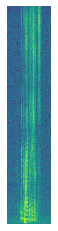

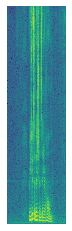

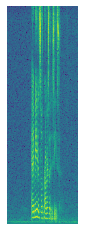

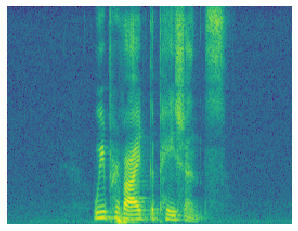

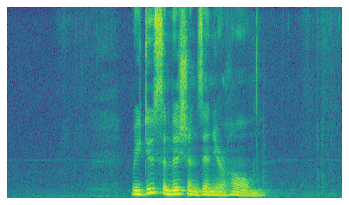

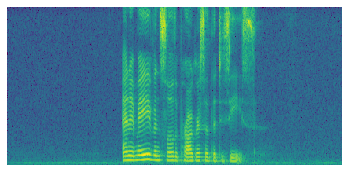

>>>>>>> remote


<<<<<<< local <unchanged>


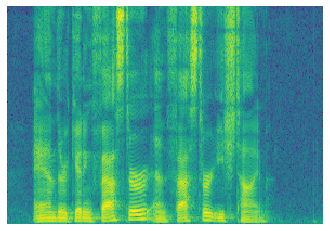

>>>>>>> remote <removed>


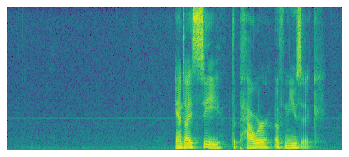

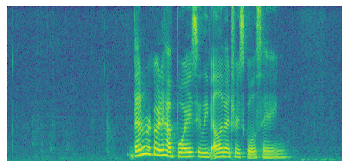

>>>>>>> remote


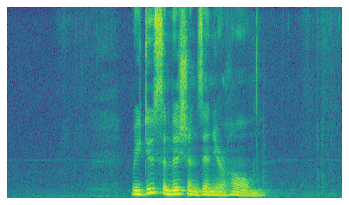

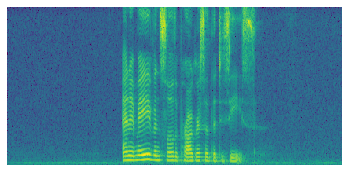

In [ ]:
oa = OpenAudio(files)
db_mel_pipe = Pipeline([oa, AudioToSpec(mel=False)], as_item=True)
for i in range(3): 
    print("Shape", i, db_mel_pipe(i).shape)
    db_mel_pipe.show(db_mel_pipe(i))

### Pipe using from_cfg (config), non-mel db-scale spectrogram 

<<<<<<< local


<<<<<<< local <modified: >


/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: f_max passed in but unused, your settings use <class 'torchaudio.transforms.Spectrogram'> not <class 'torchaudio.transforms.MelSpectrogram'>


>>>>>>> remote


<<<<<<< local <unchanged>


/home/h/miniconda3/envs/fastai_dev/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: f_max passed in but unused, your settings use <class 'torchaudio.transforms.Spectrogram'> not <class 'torchaudio.transforms.MelSpectrogram'>


/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: f_max passed in but unused, your settings use <class 'torchaudio.transforms.Spectrogram'> not <class 'torchaudio.transforms.MelSpectrogram'>


>>>>>>> remote <modified: >


<<<<<<< local


>>>>>>> remote <modified: >


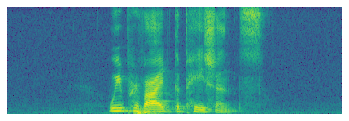

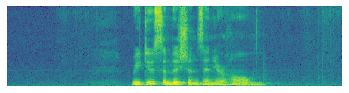

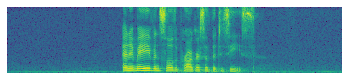

>>>>>>> remote


<<<<<<< local <unchanged>


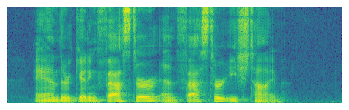

>>>>>>> remote <removed>


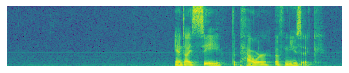

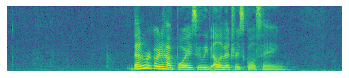

In [ ]:
cfg = {'mel':False, 'n_fft':260, 'f_max':22050., 'hop_length':128}
oa = OpenAudio(files)
db_mel_pipe = Pipeline([oa, AudioToSpec.from_cfg(cfg)], as_item=True)
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

### MFCC Pipe

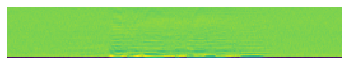

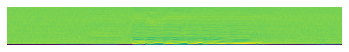

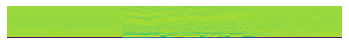

In [ ]:
db_mfcc_pipe = Pipeline([oa, AudioToMFCC(n_mfcc=40),], as_item=True)
for i in range(3): 
    db_mfcc_pipe.show(db_mfcc_pipe(i))

## Configs

<div class='alert alert-block alert-info'><strong>TO-DO:</strong><br>
    Create a config class so we can have tab completion for the options
</div>

In [ ]:
#export
def config_from_func(func, name, **kwargs):
    params = inspect.signature(func).parameters.items()
    namespace = {k:v.default for k, v in params}
    namespace.update(kwargs)
    return make_dataclass(name, namespace.keys(), namespace=namespace)

#default configurations from the wrapped function
#make sure to pass in mel=False as kwarg for non-mel spec, and to_db=False for non db spec
SpectrogramConfig    = config_from_func(_GenSpec, "SpectrogramConfig", mel=False)
MelSpectrogramConfig = config_from_func(_GenMelSpec, "MelSpectrogramConfig")
MFCCConfig           = config_from_func(_GenMFCC, "MFCCConfig")
#special configs with domain-specific defaults
VoiceMelConfig = config_from_func(_GenMelSpec, "VoiceMelConfig", f_min=50., f_max=8000., n_mels=64)

<<<<<<< local


<<<<<<< local <modified: >


MelSpectrogramConfig(sample_rate=16000, n_fft=400, win_length=None, hop_length=256, f_min=0.0, f_max=None, pad=0, n_mels=128, window_fn=<built-in method hann_window of type object at 0x7fca129fc0a0>, wkwargs=None)


>>>>>>> remote


<<<<<<< local <unchanged>


MelSpectrogramConfig(sample_rate=16000, n_fft=400, win_length=None, hop_length=None, f_min=0.0, f_max=None, pad=0, n_mels=128, window_fn=<built-in method hann_window of type object at 0x7fa38dd870a0>, wkwargs=None)


MelSpectrogramConfig(sample_rate=16000, n_fft=400, win_length=None, hop_length=None, f_min=0.0, f_max=None, pad=0, n_mels=128, window_fn=<built-in method hann_window of type object at 0x7f38675ce0a0>, wkwargs=None)


>>>>>>> remote <modified: >


>>>>>>> remote <modified: >


<<<<<<< local <modified: text/plain>


<<<<<<< local


>>>>>>> remote <modified: text/plain>


<<<<<<< local


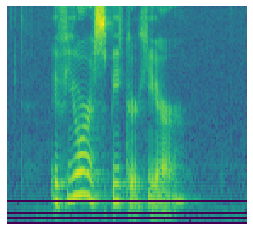

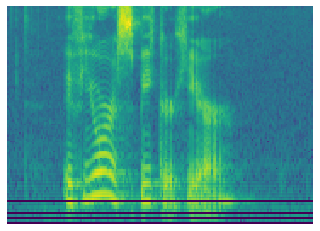

>>>>>>> remote


<<<<<<< local <unchanged>


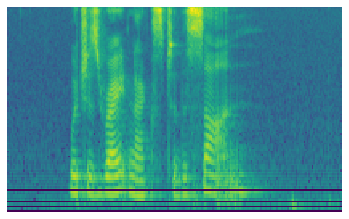

>>>>>>> remote <removed>


>>>>>>> remote


In [ ]:
mel_cfg = MelSpectrogramConfig(hop_length=256)
a2mel = AudioToSpec.from_cfg(mel_cfg)
mel = a2mel(oa(42))
print(mel_cfg)
mel.show()

In [ ]:
test_eq(mel.n_fft, mel_cfg.n_fft)
test_eq(mel.hop_length, mel_cfg.hop_length)

In [ ]:
sg_cfg = SpectrogramConfig()

In [ ]:
# make sure mel setting is passed down and is false for normal spectro
test_eq(sg_cfg.mel, False)

In [ ]:
#Grab a random file, test that the n_fft are passed successfully via config and stored in sg settings
oa = OpenAudio(files)
f_num = random.randint(0, len(files))
sg_cfg = SpectrogramConfig(n_fft=2000, hop_length=155)
a2sg = AudioToSpec.from_cfg(sg_cfg)
sg = a2sg(oa(f_num))
test_eq(sg.n_fft, sg_cfg.n_fft)
test_eq(sg.width, int(oa(f_num).nsamples/sg_cfg.hop_length)+1)

## Pipeline examples from Config

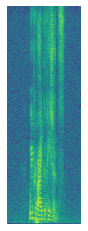

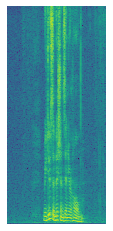

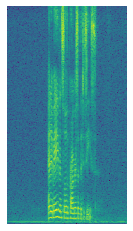

In [ ]:
oa = OpenAudio(files)
db_mel_pipe = Pipeline([oa, AudioToSpec.from_cfg(sg_cfg)], as_item=True)
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

In [ ]:
vm = VoiceMelConfig(); vm

<<<<<<< local <modified: text/plain>


VoiceMelConfig(sample_rate=16000, n_fft=400, win_length=None, hop_length=None, f_min=50.0, f_max=8000.0, pad=0, n_mels=64, window_fn=<built-in method hann_window of type object at 0x7fca129fc0a0>, wkwargs=None)

VoiceMelConfig(sample_rate=16000, n_fft=400, win_length=None, hop_length=None, f_min=50.0, f_max=8000.0, pad=0, n_mels=64, window_fn=<built-in method hann_window of type object at 0x7f38675ce0a0>, wkwargs=None)

>>>>>>> remote <modified: text/plain>


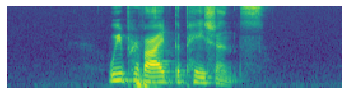

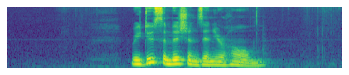

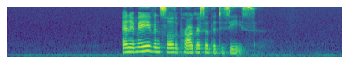

In [ ]:
oa = OpenAudio(files)
db_mel_pipe = Pipeline([oa, AudioToSpec.from_cfg(vm)], as_item=True)
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

Shape torch.Size([1, 40, 183])
Shape torch.Size([1, 40, 490])
Shape torch.Size([1, 40, 260])


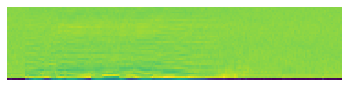

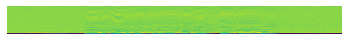

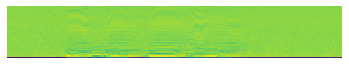

In [ ]:
mfcc_cfg = MFCCConfig()
oa = OpenAudio(files)
mfcc_pipe = Pipeline([oa, AudioToMFCC.from_cfg(mfcc_cfg)], as_item=True)
for i in range(44,47):
    print("Shape", mfcc_pipe(i).shape)
    mfcc_pipe(i).show()

## Export

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_torch_core.ipynb.
Converted 01b_script.ipynb.
Converted 01c_dataloader.ipynb.
Converted 02_data_transforms.ipynb.
Converted 03_data_pipeline.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_source.ipynb.
Converted 07_vision_core.ipynb.
Converted 08_pets_tutorial.ipynb.
Converted 09_vision_augment.ipynb.
Converted 11_layers.ipynb.
Converted 11a_vision_models_xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 15_callback_hook.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_metrics.ipynb.
Converted 21_tutorial_imagenette.ipynb.
Converted 30_text_core.ipynb.
Converted 31_text_data.ipynb.
Converted 32_text_models_awdlstm.ipynb.
Converted 33_text_models_core.ipynb.
Converted 34_callback_rnn.ipynb.
Converted 35_tutorial_wikitext.ipynb.
Conve